## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from helper import project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
## load universe_factors
fundamental_df = pd.read_csv('fundamental_20170405_20230317.csv').iloc[:,1:]
universe = pd.read_csv('all_20170405_20230317.csv')
universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d')
universe.set_index(['date'],inplace=True)
print(fundamental_df.shape, universe.shape)

(468, 5) (434522, 65)


In [3]:
print(universe.columns)

Index(['ts_code', 'trade_date', 'turnover_rate', 'amount', 'pe', 'pb',
       'total_share', 'total_mv', 'volume', 'open', 'close', 'high', 'low',
       'rsi_6', 'cci', 'name', 'industry', 'list_date', 'issue_price',
       'issue_amount', 'type', 'type_value', 'p_change_min', 'p_change_max',
       'cfps', 'revenue_ps', 'quick_ratio', 'dt_eps', 'basic_eps_yoy',
       'dt_eps_yoy', 'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt',
       'q_dt_roe', 'roe_yoy', 'capital_rese_ps', 'surplus_rese_ps',
       'gross_margin', 'interestdebt', 'ca_to_assets', 'ebt_yoy', 'or_yoy',
       'equity_yoy', 'alpha_close2open', 'supertrend', 'close_5_sma',
       'close_20_sma', 'turnover_rate_20_sma', 'log-ret', 'atr_5', 'cci_6',
       'vwma_2', 'vwma_25', 'close_10_kama_2_30', 'close_10_kama_5_30',
       'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 'alpha_supertrend',
       'alpha_cci', 'close_2_kama', 'alpha_kama', 'alpha_skew2sentiment',
       'alpha_fundamental'],
      dtype

### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [4]:
sector_dict = {'化学制药':1, '医药商业':2, '中成药':3, '生物制药':4, '互联网':5, '软件服务':6}

all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,turnover_rate,amount,pe,pb,total_share,total_mv,volume,open,...,close_2_kama,alpha_kama,alpha_skew2sentiment,alpha_fundamental,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6
date,,,,,,,,,,,,,,,,,,,,,
2017-04-05,600332.SH,20170405,1.1421,343342.10,30.4236,2.6451,162579.0949,4.587982e+06,13276.207144,26.07224,...,25.86146,-0.209804,0.001551,-0.744283,False,False,True,False,False,False
2017-04-05,603883.SH,20170405,1.0725,39643.43,39.5965,6.3533,26700.0000,1.175601e+06,1721.896511,22.97083,...,23.02312,-0.262808,0.000192,-0.542138,False,True,False,False,False,False
2017-04-05,600056.SH,20170405,0.8086,195114.36,27.0013,3.7217,106848.5534,2.560091e+06,12827.812279,14.82302,...,15.21026,-0.173759,0.000292,1.393312,False,True,False,False,False,False
2017-04-05,002410.SZ,20170405,1.8636,250567.76,40.5842,5.8010,111936.1939,1.717101e+06,17158.250099,14.93654,...,14.60334,-0.125138,0.001133,-0.193082,False,False,False,False,False,True
2017-04-05,600721.SH,20170405,1.1684,49564.59,49.4389,3.0095,40038.6394,6.878638e+05,2885.016880,17.10000,...,17.18000,-0.723628,0.001606,0.000000,False,False,False,True,False,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [5]:
quantile_jud = all_factors['log-ret'].quantile([0.5,0.5])
quantile_jud

0.5    0.0
0.5    0.0
Name: log-ret, dtype: float64

In [6]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = False
    #all_factors['return_2q'] = np.where(all_factors['log-ret']<-0.006, (-1), all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>0, True , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

In [7]:
all_factors['return_2q'].unique()

array([False,  True])

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [8]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int32)

# predict 2days
#all_factors['alpha_close2open_25_sma'] = all_factors.groupby('ts_code')['alpha_close2open_25_sma'].shift(5).fillna(method='bfill')
all_factors['alpha_fundamental'] = all_factors.groupby('ts_code')['alpha_fundamental'].shift(5).fillna(method='bfill')
#all_factors['alpha_skew2sentiment'] = all_factors.groupby('ts_code')['alpha_skew2sentiment'].shift(10).fillna(method='bfill')

universe = universe.loc[universe['trade_date']>20170601]
all_factors = all_factors.loc[all_factors['trade_date']>20170601]

### IID Check of Target
Let's see if the returns are independent and identically distributed.

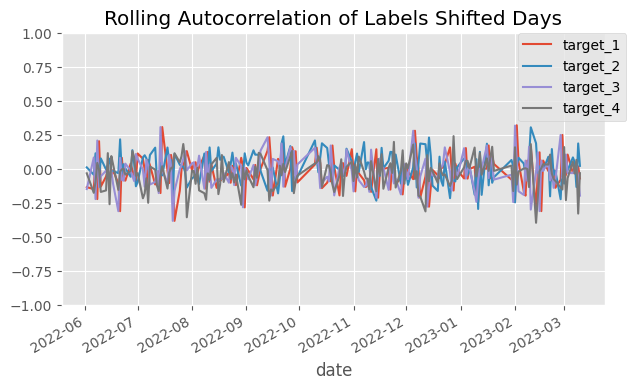

In [9]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220601]
ph.IID_check(tmp)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [10]:
features = ['turnover_rate', 'total_mv', 'atr_5', 'pe', 'pb', 'revenue_ps', 
       'alpha_cci', 'alpha_supertrend', 'alpha_kama', 'alpha_close2open', 'alpha_close2open_5_sma',
       'alpha_close2open_25_sma', 'alpha_skew2sentiment', 'alpha_fundamental'] + sector_columns
target_label = 'target'

tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label]

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.6, 0.2, 0.2)

X_test.head()

turnover_rate      total_mv     atr_5       pe      pb  \
date       ts_code                                                             
2022-01-17 300463.SZ        13.9676  1.953208e+06  2.700399  24.6021  4.7318   
           603896.SH         1.0239  8.358438e+05  2.045910  55.0941  5.6133   
           603669.SH         0.6070  6.837236e+05  0.429510  42.7133  4.9629   
           300075.SZ        18.7002  1.361652e+06  2.958428  85.8219  4.1040   
           300556.SZ        22.4303  4.169834e+05  2.794898  68.8028  5.6387   

                      revenue_ps  alpha_cci  alpha_supertrend  alpha_kama  \
date       ts_code                                                          
2022-01-17 300463.SZ      5.4043  81.011976          2.837038    2.173328   
           603896.SH      3.1496  61.377288          2.313195   -3.816424   
           603669.SH      0.9068  12.885297          0.380341   -0.402292   
           300075.SZ      2.0220  88.752840          0.312369    9.378590   
           300556.SZ      7.4426  83.846936          2.958828   -3.541375   

                      alpha_close2open  alpha_close2open_5_sma  \
date       ts_code                                               
2022-01-17 300463.SZ         -0.032764               -0.009749   
           603896.SH         -0.000547               -0.001670   
           603669.SH          0.009494               -0.001641   
           300075.SZ          0.190476                0.069975   
           300556.SZ         -0.024621               -0.004689   

                      alpha_close2open_25_sma  alpha_skew2sentiment  \
date       ts_code                                                    
2022-01-17 300463.SZ                -0.000837             -0.004186   
           603896.SH                -0.000823             -0.000141   
           603669.SH                -0.000336              0.001616   
           300075.SZ                 0.014630             -0.004909   
           300556.SZ                 0.000333              0.020513   

                      alpha_fundamental  sector_1  sector_2  sector_3  \
date       ts_code                                                      
2022-01-17 300463.SZ           1.453368     False     False     False   
           603896.SH          -0.368913     False     False      True   
           603669.SH          -0.356901      True     False     False   
           300075.SZ           0.034325     False     False     False   
           300556.SZ          -0.027180     False     False     False   

                      sector_4  sector_5  sector_6  
date       ts_code                                  
2022-01-17 300463.SZ      True     False     False  
           603896.SH     False     False     False  
           603669.SH     False     False     False  
           300075.SZ     False     False      True  
           300556.SZ     False     False      True

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [13]:
n_days = 10
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [50, 130, 250]

### Pick Important Features by Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [01:25<00:00, 28.53s/Model]


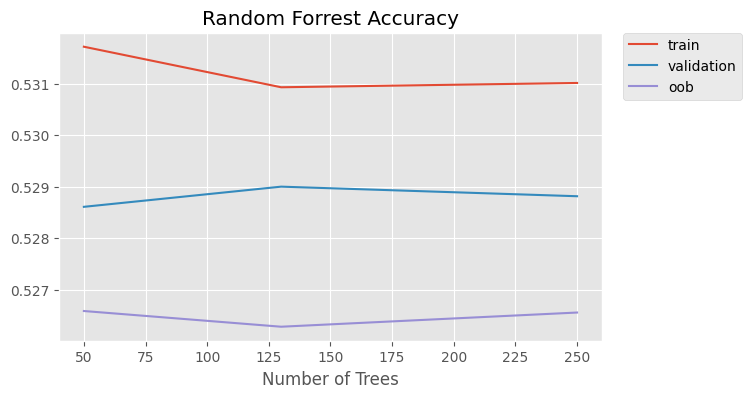

Features Ranked by Average Importance:

      Feature                     Importance
 1. alpha_kama              (0.4157122624201766)
 2. total_mv                (0.14174263992730796)
 3. alpha_close2open        (0.07422190210059736)
 4. alpha_supertrend        (0.05460238589841566)
 5. turnover_rate           (0.042362654335783824)
 6. alpha_close2open_5_sma  (0.038840634290164856)
 7. revenue_ps              (0.03509260374074513)
 8. alpha_cci               (0.03485684027164849)
 9. atr_5                   (0.03399339291858406)
10. alpha_close2open_25_sma (0.02958879631473371)
11. alpha_skew2sentiment    (0.024401809194642493)
12. alpha_fundamental       (0.0225588203723861)
13. pb                      (0.02073905771088567)
14. pe                      (0.019455807144634647)
15. sector_6                (0.004667412486318836)
16. sector_5                (0.0033703853611185713)
17. sector_4                (0.001674193342374948)
18. sector_3                (0.0014343814469906515)
19. sec

In [15]:
ph.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

#### Results
Let's compare our AI Alpha factor to a few other factors. We'll use the following:

In [56]:
factor_names = [
    'alpha_cci',
    'alpha_kama',
    'alpha_fundamental',
    'alpha_close2open_25_sma',
    'alpha_supertrend',
    'turnover_rate',
    'atr_5']
all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

ts_code,000028.SZ,000034.SZ,000150.SZ,000153.SZ,000411.SZ,000423.SZ,000513.SZ,000555.SZ,000597.SZ,000623.SZ,...,688619.SH,688639.SH,688656.SH,688658.SH,688670.SH,688687.SH,688739.SH,688777.SH,688787.SH,688799.SH
date,,,,,,,,,,,,,,,,,,,,,
2017-06-02,69.37703,NaN,12.84337,NaN,17.46547,59.57114,24.19569,NaN,NaN,19.84325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-05,67.90982,NaN,12.84337,NaN,17.38498,58.91841,23.81883,NaN,NaN,19.80077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-06,68.77343,NaN,12.85849,NaN,17.33669,59.85218,23.96496,NaN,NaN,19.84325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-07,70.73282,NaN,12.96938,NaN,17.61839,61.13045,24.43795,NaN,NaN,20.16182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-08,71.17855,NaN,12.84337,NaN,17.62644,62.72603,25.17628,NaN,NaN,20.51578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=4):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [53]:
n_days = 10
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [80, 100 ,150, 250]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [00:43<00:00, 14.37s/Model]


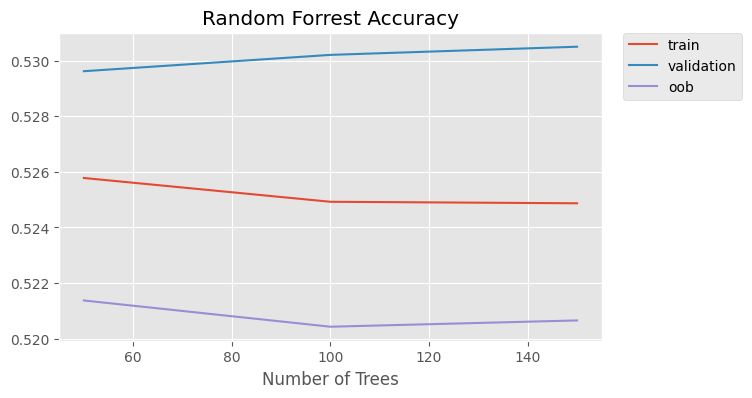

In [54]:
ph.plot(
    [n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

### Evalueate alpha factor

In [46]:
import alphalens as al

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

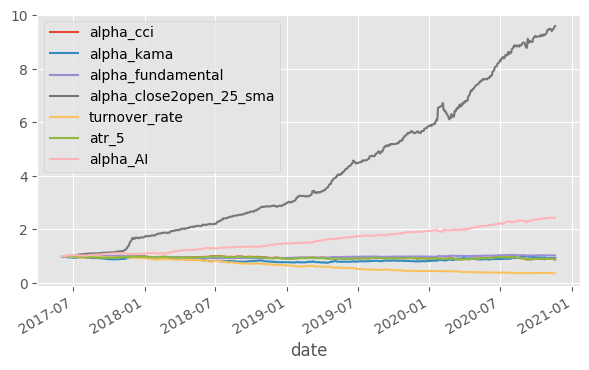

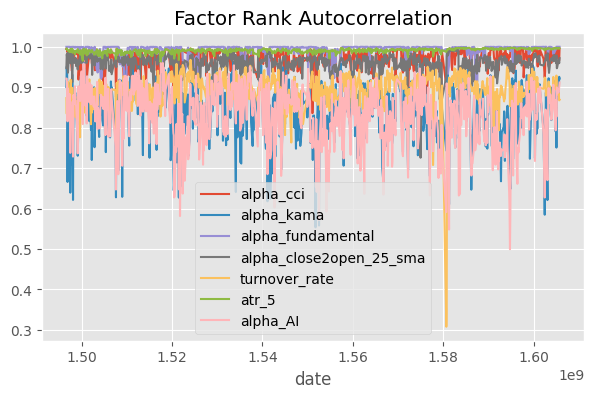

In [47]:
show_sample_results(all_factors, X_train, clf_nov, factor_names)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

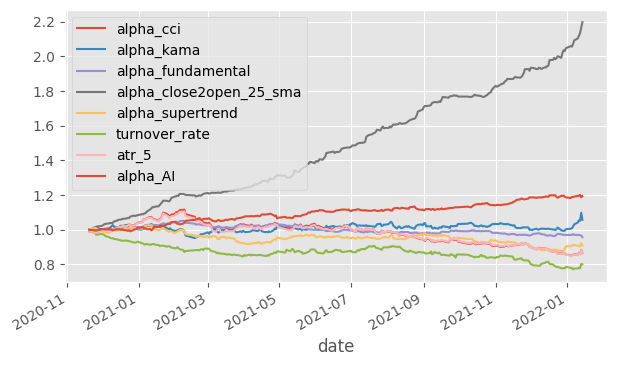

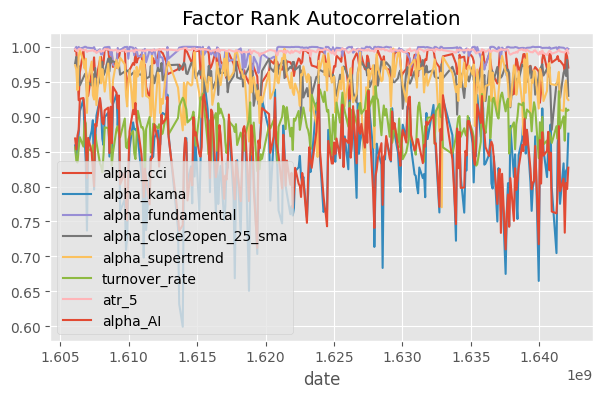

In [57]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [49]:
n_days = 10
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 150

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [50]:
print(valid_score, oob_score)

[0.5345031757993326] [0.5233607845191023]


### View Train Set Results

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

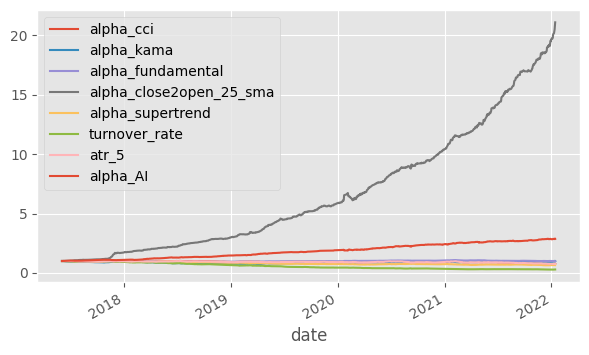

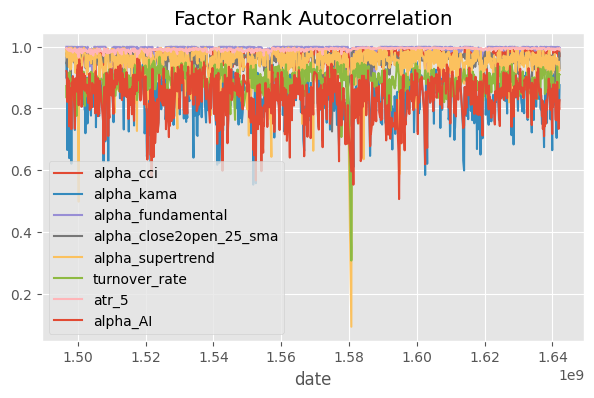

In [58]:
show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names)

### View Test Set Results

Cleaning Data...

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: O

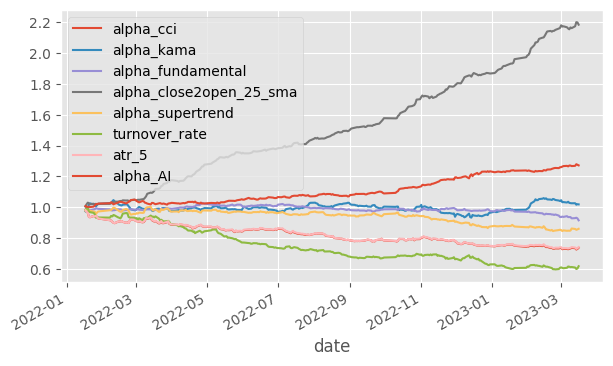

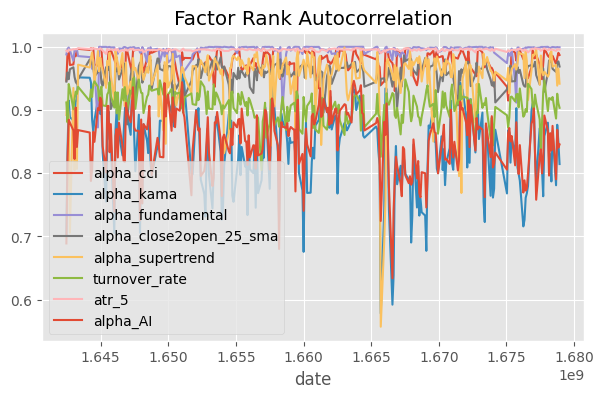

In [59]:
show_sample_results(all_factors, X_test, clf_nov, factor_names)

### Merage AI factors

In [60]:
# shift data
all_factors = universe.copy(deep=True)
# predict 2days
#all_factors['alpha_cci'] = all_factors.groupby('ts_code')['alpha_cci'].shift(2)
all_factors['alpha_fundamental'] = all_factors.groupby('ts_code')['alpha_fundamental'].shift(5)
all_factors = all_factors.fillna(method='bfill')
all_factors = all_factors.reset_index().set_index(['date', 'ts_code'])

In [61]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    return factors_with_alpha
    
all_factors = save_AI_factors(all_factors, clf_nov)
all_factors = all_factors.reset_index().set_index(['date'])
all_factors = universe.merge(all_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.04690331 -0.0519776  -0.02052605 ... -0.02290731 -0.03300029
  0.00800543] 430460


In [65]:
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret', 'return_2q', 
       'alpha_close2open', 'alpha_close2open_5_sma', 'alpha_close2open_25_sma', 
       'alpha_supertrend', 'alpha_cci', 'close_2_kama', 'alpha_kama', 'alpha_skew2sentiment',
       'alpha_fundamental','alpha_AI']
all_factors[field].to_csv('factors_AI_20170405_20230317.csv')

In [68]:
tmp = all_factors[field]
tmp = tmp.loc[tmp.industry=='化学制药']
tmp.to_csv('factor_tmp.csv')